# Amazon Reviews Recommendation System

# Attribute Information:

- userId : Every user identified with a unique id

- productId : Every product identified with a unique id

- Rating : Rating of the corresponding product by the corresponding user

- timestamp : Time of the rating ( ignore this column for this exercise)

In [2]:
# Install scikit-surprise
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 835kB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp37-cp37m-macosx_10_9_x86_64.whl size=830159 sha256=110ab07ae5699ce42c0f648aa14b240a1f7126cdc5a96f0622a167c328276419
  Stored in directory: /Users/abhaygoel/Library/Caches/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/Users/abhaygoel/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#Data Import
#Read and explore the dataset. ( Rename column, plot histograms, find data characteristics)
#Import the data set
electronics_data = pd.read_csv('ratings_Electronics.csv', names=['userId', 'productId','Rating','timestamp'])

In [3]:
# Convert timestamp into a human friendly datatime object - We'll see if we can leverage it later
electronics_data.loc[:, 'dt'] = electronics_data.timestamp.apply(lambda x: pd.datetime.fromtimestamp(x).date())


In [4]:
electronics_data.head()

,userId,productId,Rating,timestamp,dt
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200,2013-04-13
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,2012-07-01
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,2013-04-29
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,2013-07-22
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,2012-04-18


In [5]:
# Check the number of rows and columns
rows, columns = electronics_data.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  5


In [6]:
#Check info
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 5 columns):
userId       object
productId    object
Rating       float64
timestamp    int64
dt           object
dtypes: float64(1), int64(1), object(3)
memory usage: 298.5+ MB


In [7]:
# Check for missing values
print('Number of missing values across columns-\n', electronics_data.isnull().sum())

Number of missing values across columns-
 userId       0
productId    0
Rating       0
timestamp    0
dt           0
dtype: int64


There are no missing values.

In [8]:
# Summary statistics of 'rating' variable
electronics_data['Rating'].describe().transpose()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [9]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


Ratings are on scale of 1 - 5

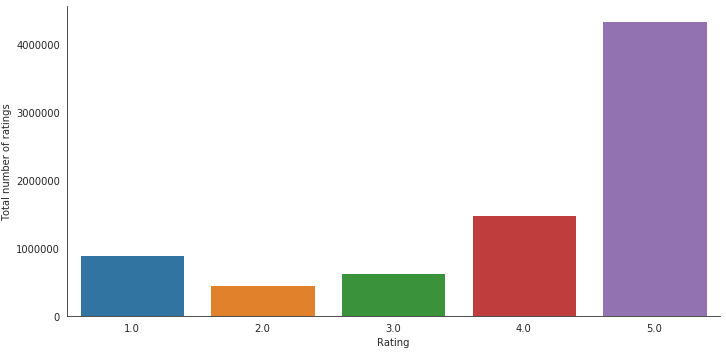

In [64]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

Most of the people has given the rating of 5

#### Unique Users and products

In [11]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 7824482
Total No of Users   : 4201696
Total No of products  : 476002


In [12]:
#Dropping the Timestamp column

electronics_data.drop(['timestamp', 'dt'], axis=1,inplace=True)

#### Analyzing Ratings

In [13]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)



In [14]:
no_of_rated_products_per_user.head(20)

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A3EXWV8FNSSFL6    282
A38RMU1Y5TDP9     282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
Name: Rating, dtype: int64

In [15]:
no_of_rated_products_per_user.describe()

count    4.201696e+06
mean     1.862220e+00
std      2.885110e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.200000e+02
Name: Rating, dtype: float64

In [16]:
#Analysis of ratings for the product

no_of_ratings_per_product = electronics_data.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

In [17]:
no_of_ratings_per_product.head(20)

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
B008OHNZI0     8966
B003LR7ME6     8840
B000LRMS66     8715
B009SYZ8OC     8370
B00BGA9WK2     7561
B004QK7HI8     7060
B009A5204K     7059
B00BGGDVOO     6893
B0098F5W0Q     6616
B002MAPRYU     6599
Name: Rating, dtype: int64

In [18]:
no_of_ratings_per_product.describe()

count    476002.000000
mean         16.437918
std         112.702633
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max       18244.000000
Name: Rating, dtype: float64

#### Make dataset less sparse/more dense

Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of 
ratings)

In [19]:
# Top 10 users based on rating
most_rated = electronics_data.groupby('userId').size().sort_values(ascending=False)[:10]
most_rated

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

Data model preparation as per requirement on number of minimum ratings.

To reduce the dimensionality of the data set, and avoid running into “memory error”, we will filter out rarely rated items and rarely rating users.


In [20]:
min_item_ratings = 50
filter_items = electronics_data['productId'].value_counts() > min_item_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 50
filter_users = electronics_data['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = electronics_data[(electronics_data['productId'].isin(filter_items)) & (electronics_data['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(electronics_data.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(7824482, 3)
The new data frame shape:	(76359, 3)


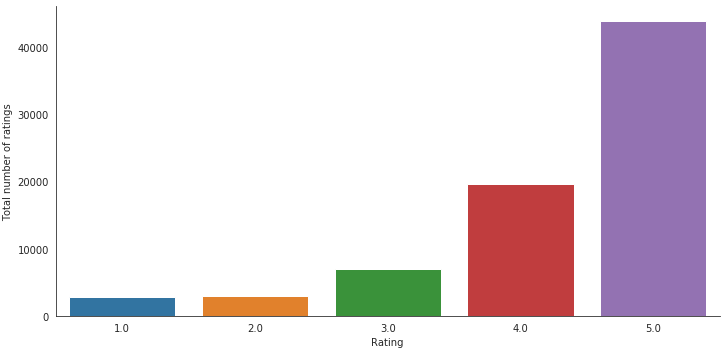

In [63]:
# Check the distribution of the rating for users 
# who have rated more than 50 items and items that have more than 50 ratings.
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=df_new, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [21]:
df_new.head()

,userId,productId,Rating
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0
1138,A25RTRAPQAJBDJ,0972683275,5.0
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0


In [22]:
print('Number of users who have rated 50 or more items =', len(df_new))
print('Number of unique USERS in final data = ', df_new['userId'].nunique())
print('Number of unique ITEMS in final data = ', df_new['productId'].nunique())

Number of users who have rated 50 or more items = 76359
Number of unique USERS in final data =  1466
Number of unique ITEMS in final data =  16555


Calculate the density of the rating matrix

In [23]:
final_ratings_matrix = df_new.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1466, 16555)
given_num_of_ratings =  76359
possible_num_of_ratings =  24269630
density: 0.31%


In [24]:
final_ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Popularity Based Recommendation
Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.

The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.

In [25]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400532620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
final_ratings_matrix_T.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16555 entries, 0972683275 to B00L3YHF6O
Columns: 1466 entries, A100UD67AHFODS to AZOK5STV85FBJ
dtypes: float64(1466)
memory usage: 185.9+ MB


In [27]:
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_new, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,Rating
2817358,A2HNH4PKE5DPSI,B002RWJHBM,5.0
2355057,ABSYIF0ONC2AF,B001UI2FPE,5.0
3175399,AKSQNMIKOU01H,B0039VYN1Y,5.0
811946,A2GMZZ6TDYOHY7,B000CRFOMK,5.0
6113054,A3R19YKNL641X3,B0088PPFP4,4.0


In [28]:
train_data.shape
test_data.shape

(53451, 3)

(22908, 3)

# Build Popularity Recommender model. (Non-personalised)

In [29]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head()

,productId,score
0,0972683275,2
1,1400501466,4
2,1400501520,1
3,1400501776,1
4,1400532620,2


In [30]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
11896,B0088CJT4U,134,1.0
7316,B003ES5ZUU,120,2.0
2835,B000N99BBC,115,3.0
11792,B00829TIEK,101,4.0
12008,B008DWCRQW,100,5.0


In [31]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [32]:
test_data.head(15)

,userId,productId,Rating
1134407,A3TBMGNSEQBWIL,B000LRMS66,5.0
1187282,A12DQZKRKTNF5E,B000MYPPPE,4.0
4693748,A38RMU1Y5TDP9,B0054L8N7M,5.0
3978249,A2Y3WWPUKIJ59I,B004A7ZEI2,4.0
4024424,A25C2M3QF9G7OQ,B004CLYEDC,4.0
4902769,A781ITP3HE2N5,B005FDOG1G,4.0
2485831,A376OJHLE6SU9Q,B0028Y4CWI,5.0
7481890,A1PPS91NLI7KEH,B00E0EY7Z6,5.0
7196096,A25UZ7MA72SMKM,B00BZC31WQ,3.0
7276061,A2N75ADJSRW0AH,B00CL8F98W,2.0


In [33]:
find_recom = ['A3JU990UTN5RQP','A25UZ7MA72SMKM','AI8EMB0HUC6Z5']   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: A3JU990UTN5RQP

               userId   productId  score  Rank
11896  A3JU990UTN5RQP  B0088CJT4U    134   1.0
7316   A3JU990UTN5RQP  B003ES5ZUU    120   2.0
2835   A3JU990UTN5RQP  B000N99BBC    115   3.0
11792  A3JU990UTN5RQP  B00829TIEK    101   4.0
12008  A3JU990UTN5RQP  B008DWCRQW    100   5.0


Here is the recommendation for the userId: A25UZ7MA72SMKM

               userId   productId  score  Rank
11896  A25UZ7MA72SMKM  B0088CJT4U    134   1.0
7316   A25UZ7MA72SMKM  B003ES5ZUU    120   2.0
2835   A25UZ7MA72SMKM  B000N99BBC    115   3.0
11792  A25UZ7MA72SMKM  B00829TIEK    101   4.0
12008  A25UZ7MA72SMKM  B008DWCRQW    100   5.0


Here is the recommendation for the userId: AI8EMB0HUC6Z5

              userId   productId  score  Rank
11896  AI8EMB0HUC6Z5  B0088CJT4U    134   1.0
7316   AI8EMB0HUC6Z5  B003ES5ZUU    120   2.0
2835   AI8EMB0HUC6Z5  B000N99BBC    115   3.0
11792  AI8EMB0HUC6Z5  B00829TIEK    101   4.0
12008  AI8EMB0HUC6Z5  B008

Since this is a popularity-based recommender model, recommendations remain the same for all users

We predict the products based on the popularity. It is not personalized to particular user

# Build Collaborative Filtering model.

### Model-based Collaborative Filtering: Singular Value Decomposition

In [34]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,userId,productId,Rating
0,2817358,A2HNH4PKE5DPSI,B002RWJHBM,5.0
1,2355057,ABSYIF0ONC2AF,B001UI2FPE,5.0
2,3175399,AKSQNMIKOU01H,B0039VYN1Y,5.0
3,811946,A2GMZZ6TDYOHY7,B000CRFOMK,5.0
4,6113054,A3R19YKNL641X3,B0088PPFP4,4.0


In [35]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
pivot_df.shape
pivot_df.head()

(1466, 16555)

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


# SVD method

### SVD is best to apply on a large sparse matrix

De-mean the data (normalize by each users mean) and convert it from a dataframe to a numpy array

In [37]:
R = pivot_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [38]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

# the Σ (Sigma) returned is just the values instead of a diagonal matrix. This is useful, 
# but since I’m going to leverage matrix multiplication to get predictions I’ll convert it to 
# the diagonal matrix form.
# Construct diagonal array in SVD
sigma = np.diag(sigma)


##### Making Predictions from the Decomposed Matrices

I now have everything I need to make product ratings predictions for every user. I can do it all at once by following the math and matrix multiply U, Σ, and VT back to get the rank k=10 approximation of R.

I also need to add the user means back to get the predicted 5-star ratings.

In [39]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)

In [40]:

def recommend_items(userId, pivot_df, preds_df, num_recommendations):
      
    # Get and sort the user's ratings
    user_idx = int(pivot_df.loc[userId]["user_index"])
    sorted_user_ratings = pivot_df.loc[userId].sort_values(ascending=False)
    
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(userId = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [41]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = "A10AFVU66A79Y1"
num_recommendations = 10
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(userId = A10AFVU66A79Y1):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          0.816939
B003ES5ZUU                  0.0          0.771339
B004CLYEDC                  0.0          0.724615
B00829TIEK                  0.0          0.704155
B000N99BBC                  0.0          0.635137
B008DWCRQW                  0.0          0.624695
B004CLYEFK                  0.0          0.568397
B00829THK0                  0.0          0.494212
B00834SJSK                  0.0          0.484834
B0034CL2ZI                  0.0          0.420568


In [42]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = "A110VKXAVLAYKY"
num_recommendations = 10
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(userId = A110VKXAVLAYKY):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.159075
B000QUUFRW                  0.0          0.121043
B002WE6D44                  0.0          0.113118
B002V88HFE                  0.0          0.112806
B00004ZCJE                  0.0          0.092231
B000JMJWV2                  0.0          0.083204
B005HMKKH4                  0.0          0.076208
B00009XVCZ                  0.0          0.075415
B000KO0GY6                  0.0          0.073590
B000LRMS66                  0.0          0.073348


Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on 
predictions made on the test data.)

Evaluation of Model-based Collaborative Filtering (SVD)

In [43]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
0972683275    0.010232
1400501466    0.010232
1400501520    0.003411
1400501776    0.006139
1400532620    0.004093
dtype: float64

In [45]:
# Predicted ratings 
preds_df.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O,user_index
0,0.017282,0.015825,0.024262,0.033954,0.026385,0.030639,0.024585,0.022169,0.025437,0.027121,...,0.475112,0.049002,0.068969,0.042092,0.060769,0.011058,0.087154,0.026557,0.465199,0.026161
1,0.052290,0.010908,0.010173,0.045905,0.022212,0.020604,0.012047,0.025505,0.022895,0.021446,...,0.012702,0.027930,0.034590,0.068164,0.248853,0.076110,0.017678,0.036011,0.123920,1.023511
2,0.022973,0.005881,0.005382,0.012236,0.013604,-0.004119,0.006349,0.014818,0.007306,0.008393,...,-0.004455,0.010651,0.023470,0.040346,0.248030,0.080206,0.006903,0.014050,0.087901,2.011603
3,0.019242,0.009690,0.013150,0.015513,0.011657,0.015227,0.012983,0.008642,0.017222,0.013557,...,0.032714,0.003688,0.018532,0.023542,-0.002777,0.027719,0.002395,0.013582,0.062594,3.014103
4,0.019647,0.009120,0.009406,0.018593,0.013793,0.008779,0.010058,0.016095,0.010870,0.011884,...,0.046559,0.008220,0.016080,0.034725,0.125267,0.041076,0.011339,0.017359,0.115121,4.013849


In [46]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
0972683275    0.068160
1400501466    0.066668
1400501520    0.060925
1400501776    0.062426
1400532620    0.058970
dtype: float64

In [47]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(16556, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
0972683275,0.010232,0.068160,0
1400501466,0.010232,0.066668,1
1400501520,0.003411,0.060925,2
1400501776,0.006139,0.062426,3
1400532620,0.004093,0.058970,4


In [48]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0569 



### Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [49]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = "A3JU990UTN5RQP"
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(userId = A3JU990UTN5RQP):

                   user_ratings  user_predictions
Recommended Items                                
B003ES5ZUU                  0.0          1.026813
B005FYNSPK                  0.0          0.708062
B005HMKKH4                  0.0          0.530533
B00E3W15P0                  0.0          0.421251
B002V88HFE                  0.0          0.415556


In [50]:

# Enter 'userID' and 'num_recommendations' for the user #
userID = "A25UZ7MA72SMKM"
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(userId = A25UZ7MA72SMKM):

                   user_ratings  user_predictions
Recommended Items                                
B004CLYEDC                  0.0          2.002054
B0034CL2ZI                  0.0          1.534730
B008DWCRQW                  0.0          1.519411
B00829TIEK                  0.0          1.448643
B0079UAT0A                  0.0          1.398158


### Summary

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user. You can see the differance above for the user id A25UZ7MA72SMKM & A3JU990UTN5RQP, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the 
user past purchase history

### KNN Based Approach

##### Item-Item Filter

In [51]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.reader import Reader

In [106]:
data = Dataset.load_from_df(df_new, Reader(rating_scale=(1,5)))
trainset, testset = train_test_split(data, test_size=.15)

In [107]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [108]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [88]:
test_pred

[Prediction(uid='A3FEGTOLCWXSV4', iid='B008EQZ25K', r_ui=4.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A14I1F2H7NOYDC', iid='B005FYNSPK', r_ui=5.0, est=4.428571428571429, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A16WP8NTPYB0ZM', iid='B0031GNYCQ', r_ui=2.0, est=4.29359600381658, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1VTCSCH8FFC76', iid='B003BYRMEO', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2NOW4U7W3F7RI', iid='B0033WSDR4', r_ui=5.0, est=3.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A18OTCHQ6MXD6X', iid='B005ES0YYA', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2VALCFTOWFYXZ', iid='B00IDG3IDO', r_ui=3.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A100UD67AHFODS', iid='B00998P7UW', r_ui=5.0, est=4.0, details={'actual_k': 0, 'was_im

In [109]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.1287


1.1287279004875261

In [110]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [111]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
5855,A2HMF8ZR67BNZS,B0001MQUOM,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",84,1,0.0
1810,A3N8O68DOEQ2FE,B00461E7JE,5.0,5.0,"{'actual_k': 4, 'was_impossible': False}",34,22,0.0
3593,A13WOT3RSXKRD5,B002WE6D44,5.0,5.0,"{'actual_k': 6, 'was_impossible': False}",41,79,0.0
7778,A291XTI6NO7DEG,B00007LTB6,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",24,1,0.0
1814,A23ZXHFLC6TBLD,B002IT1C8U,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",46,1,0.0
6385,A2VODABWSVHV8E,B003L77Y5I,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",45,3,0.0
7775,A247L282PID4PE,B0011WHFPE,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",27,1,0.0
4442,A33152QEGO2MZN,B000IJY8DS,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",46,11,0.0
11016,A3GX0FAMEXV6FB,B006588Z7G,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",38,2,0.0
7772,A4H4KYSM2KQ85,B002V8C3W2,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",30,40,0.0


In [112]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
10161,A1WF4QNIE2Z3I7,B005JE3VYY,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",49,4,4.0
5150,A2CIQEY05SPHTZ,B000NK6DZI,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",41,1,4.0
5363,A28J3123I1QDKI,B001A4HAFS,1.0,5.0,"{'actual_k': 2, 'was_impossible': False}",30,12,4.0
5365,A3CG93783LP0FO,B0035JAE0O,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",122,1,4.0
5453,A5KMMY627T3W,B002PHM0XQ,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",71,1,4.0
5573,AL1XV4L25FZ2S,B004J3Y9U6,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",50,3,4.0
5671,AU3GYRAKBUAEU,B00191PKJK,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",42,2,4.0
855,A23WPWLYT3P1CZ,B0002MQGKO,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",37,1,4.0
6765,A2HMF8ZR67BNZS,B004PDY8QK,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",84,1,4.0
9076,A2SKEQT0WTB954,B0001M4E72,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",56,1,4.0


Lets try to make sense of the worst predictions. product with ID B001A4HAFS, is predicted as 5 while real user rating is 1. 

Plot ratings for product Id B001A4HAFS.

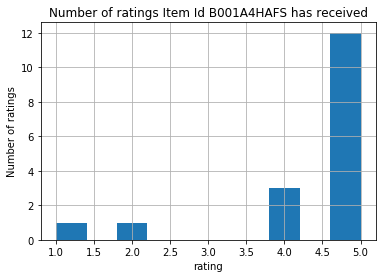

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
df_new.loc[df_new['productId'] == 'B001A4HAFS']['Rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings Item Id B001A4HAFS has received')
plt.show();


#### Insight
It turns out, most of the ratings this product received was 5, in another word, most of the users in the data rated this product 5, only very few users rated 1. Same with the other predictions in “worst predictions” list. It seems that for each prediction, the users are some kind of outsiders. 